# Image Segmentation with U-Net (4 blocks instead of the original 5)

The U-Net architecture is shown below with 6 blocks instead of the 5 we saw in the discussion.


![](https://drive.google.com/uc?export=view&id=1GSGmPRgnTIm7nLUoGcaXdLaJIs175RRH)

<a name='1'></a>
# 1 - Packages

In [ ]:
# for data load
import os

# for reading and processing images
import imageio
from PIL import Image

# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from sklearn.model_selection import train_test_split

<a name='2'></a>
# 2 - Helper Functions for Data Processing

<a name='2.1'></a>
## 2.1 - Load Data
* the masked images are stored as png
* unmasked (original) as jpg
* the names of these 2 are same so for getting the right sample we can just sort the 2 lists

In [ ]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively
    
    """
    # Read the images folder like a list
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    for file in image_dataset:
        if ".mat" not in file:
          orig_img.append(file)
    for file in mask_dataset:
        if file[0] != ".":
          mask_img.append(file)

    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    orig_img.sort()
    mask_img.sort()

    return orig_img, mask_img

In [ ]:
images = "https://drive.google.com/file/d/1ZU6A0IjQOwqacKqxUD0fjpIxpX0So3W5/view?usp=sharing"
masks = "https://drive.google.com/file/d/15rtN996xgEIMbEOBQFfrDIE0c-X0UsHM/view?usp=sharing"

In [ ]:
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile

# Google Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download data files
downloaded = drive.CreateFile({'id':"1ZU6A0IjQOwqacKqxUD0fjpIxpX0So3W5"})
downloaded.GetContentFile('images.zip')


zip_ref = zipfile.ZipFile("images.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

# Download data files
downloaded = drive.CreateFile({'id':"1Q4ptdCmE99D_KNOjGWtREInMW-AWbB_Y"})
downloaded.GetContentFile('masks.zip')


zip_ref = zipfile.ZipFile("masks.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
path1 = '/tmp/images/'
path2 = '/tmp/trimaps/'
img, mask = LoadData (path1, path2)

In [ ]:
img[7389]

'yorkshire_terrier_99.jpg'

In [ ]:
mask[7389]

'yorkshire_terrier_99.png'

<a name='2.2'></a>
## 2.2 - Pre-Process Data

In [ ]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel (scalar values)
    With an integer as either 0, 1, 2.
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask
    
    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)
    
    # Resize images and masks
    for file in img:
        # convert image into an array of desired shape (3 channels)
        index = img.index(file) # Find the index of the file
        path = os.path.join(path1, file) # Get the full path
        single_img = Image.open(path).convert('RGB') # Open the image
        single_img = single_img.resize((i_h,i_w)) # Resuze
        single_img = np.reshape(single_img,(i_h,i_w,i_c)) # Numpy object
        single_img = single_img/255 # Normalise
        X[index] = single_img # This is our X at position index
        
        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = mask[index] # Get the corresponding mask file name
        path = os.path.join(path2, single_mask_ind) # Get the fukll path
        single_mask = Image.open(path) # Open the mask
        single_mask = single_mask.resize((m_h, m_w)) # Reize
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c)) # Numpy object
        single_mask = single_mask - 1 #Reset the value of each pixel by subtracting 1 from each pixel
        # This is because the sparsecategorical cross entropy requires that the classes scalar values
        # start from zero
        y[index] = single_mask
    return X, y

<a name='3'></a>
#3 - Constructing the U-Net Architecture


<a name='3.1'></a>
## 3.1 - U-Net Encoder Block

In [ ]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow 
    # Proper initialization prevents from the problem of exploding and vanishing gradients 
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size) 
    conv = Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    # Here we return two things so that we can use the skip connection
    # in the decoder!
    return next_layer, skip_connection

<a name='3.2'></a>
## 3.2 - U-Net Decoder Block

In [ ]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

<a name='3.3'></a>
## 3.3 - Compile U-Net Blocks

In [ ]:
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=3):
    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output 
    """
    # Input size represent the size of 1 image (the size used for pre-processing) 
    inputs = Input(input_size)

    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    # Notice the index zero below, this is because the encoder only uses the output
    # from the feature map, and not the skip connection (the encoder returns two things!)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=False)

    ublock5 = DecoderMiniBlock(cblock4[0], cblock3[1],  n_filters * 4)
    ublock6 = DecoderMiniBlock(ublock5, cblock2[1],  n_filters * 2)
    ublock7 = DecoderMiniBlock(ublock6, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Remember that 1x1 conv allows us to adjust the number of channels
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(ublock7)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

<a name='4'></a>
# 4 - Executing above Functions to Train the Model

<a name='4.1'></a>
## 4.1 - Load and View Data

(400, 600, 3)
(400, 600)


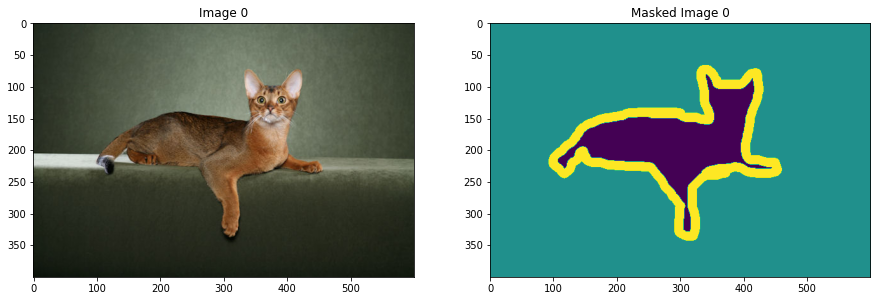

In [ ]:
""" Load Train Set and view some examples """

# View an example of image and corresponding mask 
show_images = 1
for i in range(show_images):
    img_view  = imageio.imread(path1 + img[i])
    mask_view = imageio.imread(path2 + mask[i])
    print(img_view.shape)
    print(mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Masked Image '+ str(i))

<a name='4.2'></a>
## 4.2 - Process Data

In [ ]:
# Define the desired shape
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

# Process data using apt helper function
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

X Shape: (7390, 128, 128, 3)
Y shape: (7390, 128, 128, 1)
[0 1 2]


Text(0.5, 1.0, 'Processed Masked Image ')

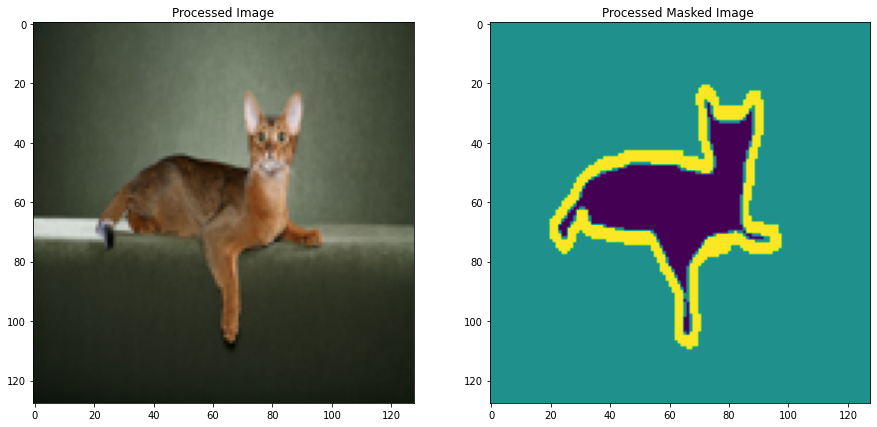

In [ ]:
# QC the shape of output and classes in output dataset 
print("X Shape:", X.shape) # We expect the shapes to match (not the depth though)
print("Y shape:", y.shape)
# There are 3 classes : background, pet, outline
print(np.unique(y)) #Here we expect [0,1,2]

# Visualize the output
image_index = 0
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

## 4.3 - Split Train and Test Set

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

<a name='4.4'></a>
## 4.4 - Build U-Net Architecture

In [ ]:
# Call the helper function for defining the layers for the model, given the input image size
unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=3)

In [ ]:
# Check the summary to better interpret how the output dimensions change in each layer
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_16[0][0]']              
                                )                                                           

<a name='4.5'></a>
## 4.5 - Compile and Run Model

In [ ]:
unet.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Again we have from_logits = True because we have not normalised our output
# Had we applied a softmax, then we would need to use categorical cross entropy
# And also one-hot encoding the masks. This approach seems simpler.

## View the performance before training

In [ ]:
# Results of Validation Dataset
def VisualizeResults(index):
    img = X_valid[index] # Get a validation image
    img = img[np.newaxis, ...] # This is a batch of size 1
    pred_y = unet.predict(img) # Predict
    pred_mask = tf.argmax(pred_y[0], axis=-1) # Find the channel with the largest value
    # This will return a 128x128 object
    print(pred_mask.shape)
    pred_mask = pred_mask[..., tf.newaxis] # Add a new depth to visualise the mask
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

(128, 128)


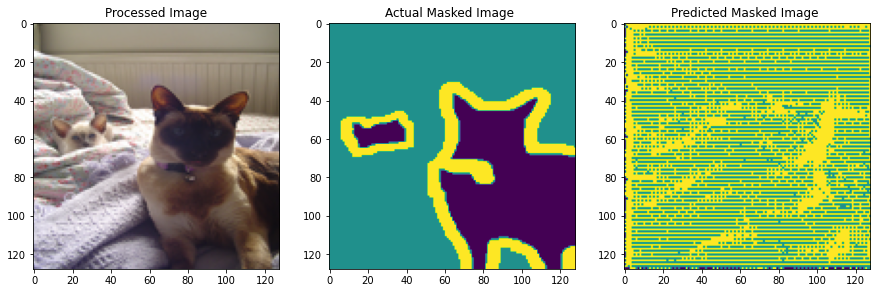

In [ ]:
# Add any index to contrast the predicted mask with actual mask
index = 700
VisualizeResults(index)

In [ ]:
# Run the model in a mini-batch fashion and compute the progress for each epoch
results = unet.fit(X_train, y_train, batch_size=32, epochs=6, validation_data=(X_valid, y_valid))

Epoch 1/6
185/185 [==============================] - 33s 175ms/step - loss: 0.7197 - accuracy: 0.7010 - val_loss: 0.5835 - val_accuracy: 0.7666
Epoch 2/6
185/185 [==============================] - 33s 176ms/step - loss: 0.5540 - accuracy: 0.7808 - val_loss: 0.4876 - val_accuracy: 0.8105
Epoch 3/6
185/185 [==============================] - 32s 173ms/step - loss: 0.4637 - accuracy: 0.8193 - val_loss: 0.4486 - val_accuracy: 0.8260
Epoch 4/6
185/185 [==============================] - 32s 174ms/step - loss: 0.4158 - accuracy: 0.8391 - val_loss: 0.4142 - val_accuracy: 0.8378
Epoch 5/6
185/185 [==============================] - 32s 175ms/step - loss: 0.3802 - accuracy: 0.8540 - val_loss: 0.3771 - val_accuracy: 0.8543
Epoch 6/6
185/185 [==============================] - 32s 174ms/step - loss: 0.3605 - accuracy: 0.8615 - val_loss: 0.3699 - val_accuracy: 0.8581


<a name='5'></a>
# 5 - Evaluate Model Results

<a name='5.1'></a>
## Check training loss

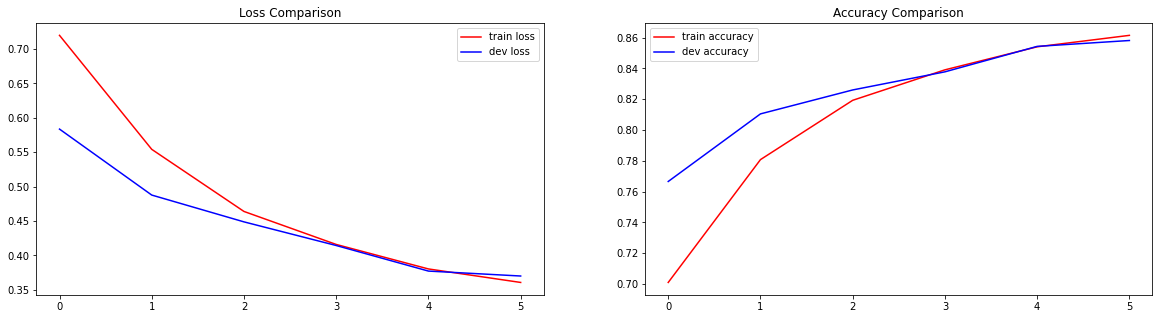

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

<a name='5.2'></a>
## 5.2 - View Predicted Segmentations

In [ ]:
unet.evaluate(X_valid, y_valid)

47/47 [==============================] - 2s 51ms/step - loss: 0.3699 - accuracy: 0.8581


[0.36989009380340576, 0.8581152558326721]

In [ ]:
# Results of Validation Dataset
def VisualizeResults(index):
    img = X_valid[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

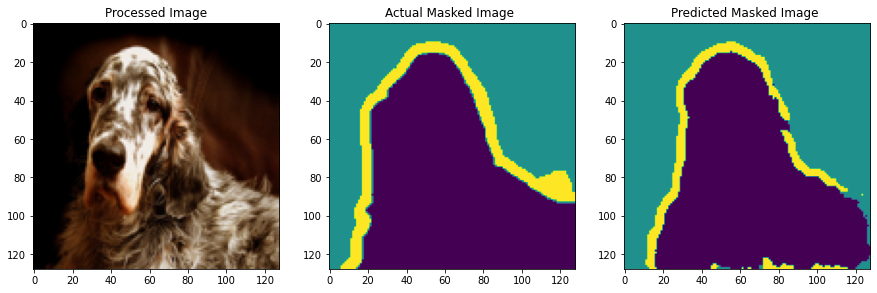

In [ ]:
# Add any index to contrast the predicted mask with actual mask
index = 701
VisualizeResults(index)